# AI-Powered Digital Carbon Footprint Tracker — Training Notebook
### Regression + Reinforcement Learning (DQN)

**Author:** Dasari Ushodaya

**Files expected:**
- `Carbon Emission.csv` in the project root (same folder as this notebook)
- `models/` folder will be created automatically to save trained artifacts

**What this notebook does:**
1. Load and explore your dataset
2. Engineer features from categorical and list-like columns
3. Train and compare models (Linear Regression, RandomForest, HistGradientBoosting)
4. Save the best-performing pipeline (`models/carbon_rf_pipeline_final.joblib`)
5. Train a tiny DQN agent that learns to suggest a single action to reduce predicted emissions
6. Save the DQN agent (`models/dqn_carbon_agent_final.zip`)
7. Run sanity checks and visualize before/after emissions


In [4]:
# ============== 1) Imports & Setup ==============
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# Try to import RL stack; if fails, skip RL
SB3_AVAILABLE = True
try:
    import gymnasium as gym
    from gymnasium import spaces
    from stable_baselines3 import DQN
    from stable_baselines3.common.env_util import make_vec_env
except Exception as e:
    SB3_AVAILABLE = False
    print("[INFO] Reinforcement Learning libraries not available - RL section will be skipped.", e)

# Paths
DATA_PATH = "Carbon Emission.csv"   # file must be in same folder as notebook
MODELS_DIR = "models"
os.makedirs(MODELS_DIR, exist_ok=True)

# Possible RL actions
ACTIONS = [
    "no_change",
    "reduce_car_frequency",
    "switch_to_public_transport",
    "reduce_meat_consumption",
    "switch_to_renewable_energy",
    "increase_recycling",
]


## 2) Load Dataset

In [5]:
# ============== 2) Load Dataset ==============
df = pd.read_csv(DATA_PATH)

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)

# Show first 5 rows
display(df.head())

# Show column types
print("\nColumn types:")
print(df.dtypes)

# Show missing values
print("\nMissing values per column:")
print(df.isna().sum())

✅ Dataset loaded successfully!
Shape: (10000, 20)


,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743



Column types:
Body Type                        object
Sex                              object
Diet                             object
How Often Shower                 object
Heating Energy Source            object
Transport                        object
Vehicle Type                     object
Social Activity                  object
Monthly Grocery Bill              int64
Frequency of Traveling by Air    object
Vehicle Monthly Distance Km       int64
Waste Bag Size                   object
Waste Bag Weekly Count            int64
How Long TV PC Daily Hour         int64
How Many New Clothes Monthly      int64
How Long Internet Daily Hour      int64
Energy efficiency                object
Recycling                        object
Cooking_With                     object
CarbonEmission                    int64
dtype: object

Missing values per column:
Body Type                           0
Sex                                 0
Diet                                0
How Often Shower             

## 3) Exploratory Data Analysis (EDA)

,Monthly Grocery Bill,Vehicle Monthly Distance Km,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,CarbonEmission
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,173.875200,2031.485900,4.024600,12.139200,25.109000,11.889100,2269.147300
std,72.234018,2769.715597,1.990375,7.106369,14.698725,7.277218,1017.675247
min,50.000000,0.000000,1.000000,0.000000,0.000000,0.000000,306.000000
25%,111.000000,69.000000,2.000000,6.000000,13.000000,6.000000,1538.000000
50%,173.000000,823.000000,4.000000,12.000000,25.000000,12.000000,2080.000000
75%,237.000000,2516.750000,6.000000,18.000000,38.000000,18.000000,2768.000000
max,299.000000,9999.000000,7.000000,24.000000,50.000000,24.000000,8377.000000



Missing values per column:
 Vehicle Type                     6721
Body Type                           0
Waste Bag Size                      0
Cooking_With                        0
Recycling                           0
Energy efficiency                   0
How Long Internet Daily Hour        0
How Many New Clothes Monthly        0
How Long TV PC Daily Hour           0
Waste Bag Weekly Count              0
Vehicle Monthly Distance Km         0
Sex                                 0
Frequency of Traveling by Air       0
Monthly Grocery Bill                0
Social Activity                     0
Transport                           0
Heating Energy Source               0
How Often Shower                    0
Diet                                0
CarbonEmission                      0
dtype: int64


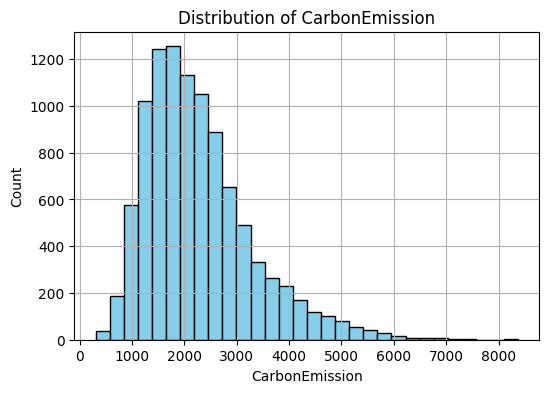

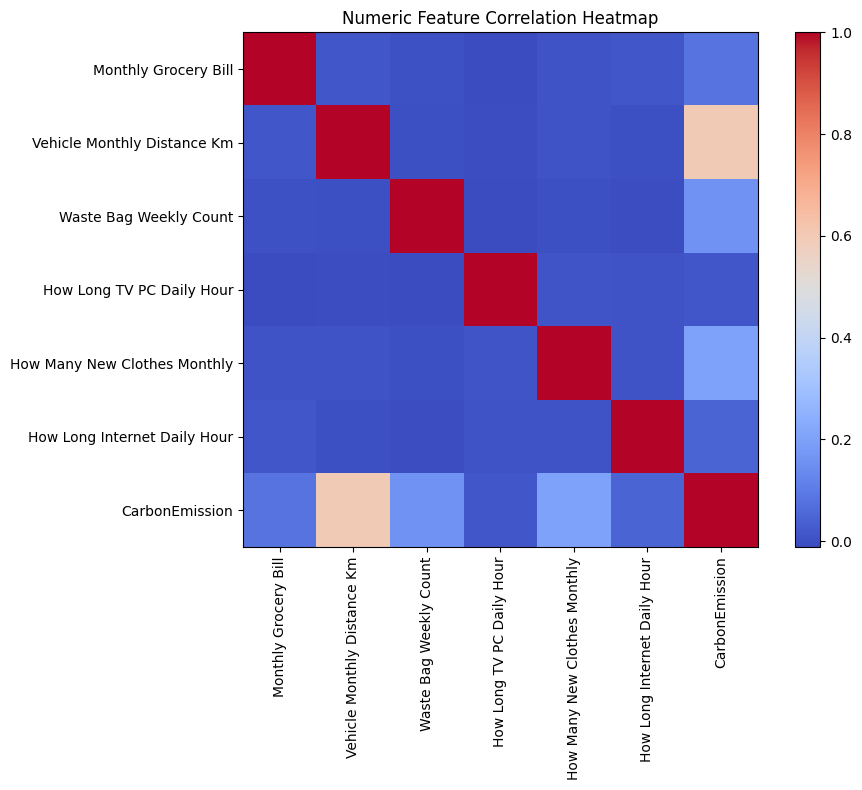

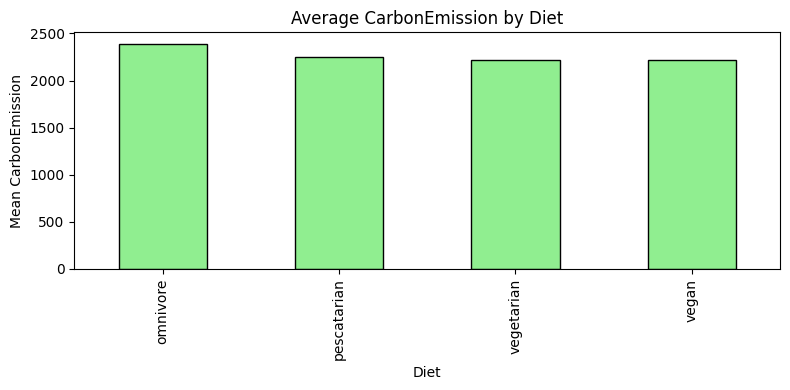

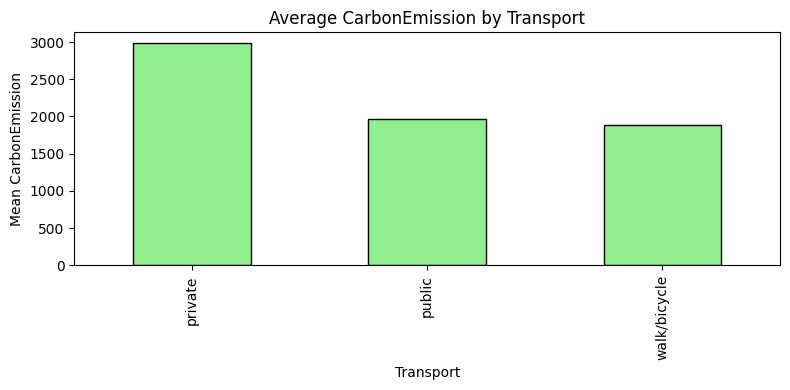

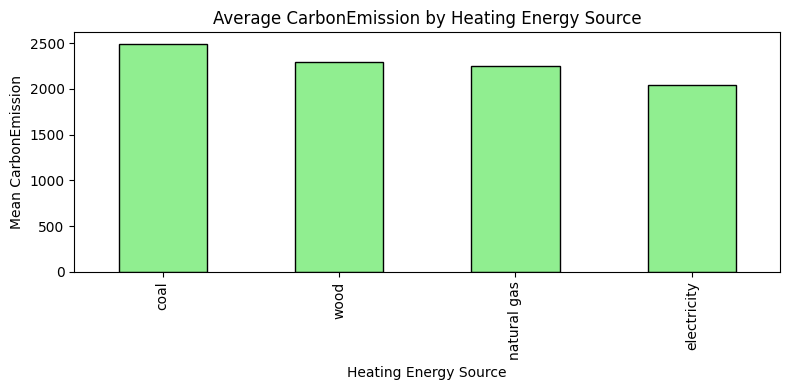

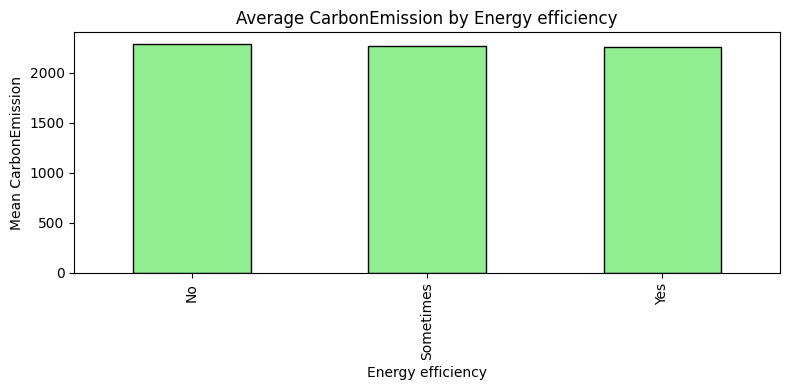

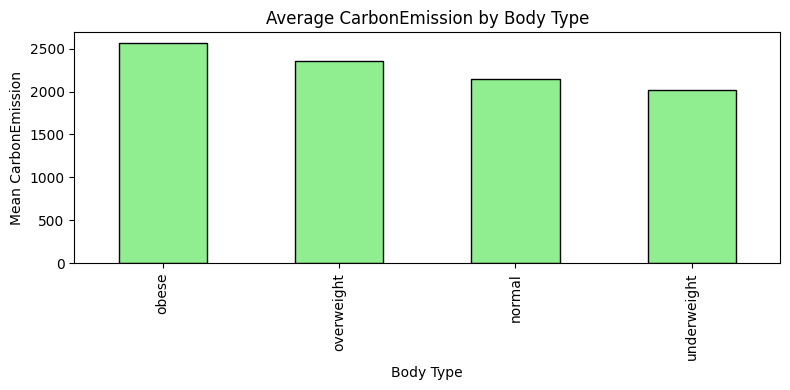

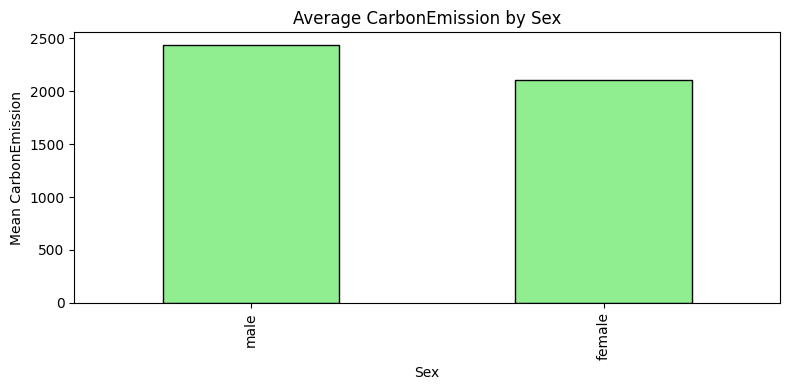

In [6]:
# ============== 3) Exploratory Data Analysis (EDA) ==============

# Summary stats for numeric columns
display(df.describe())

# Missing values per column
missing = df.isna().sum().sort_values(ascending=False)
print("\nMissing values per column:\n", missing)

# Distribution of CarbonEmission
plt.figure(figsize=(6,4))
df['CarbonEmission'].hist(bins=30, color="skyblue", edgecolor="black")
plt.title('Distribution of CarbonEmission')
plt.xlabel('CarbonEmission')
plt.ylabel('Count')
plt.show()

# Simple numeric correlation heatmap
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
corr = df[numeric_cols].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, interpolation='nearest', cmap="coolwarm")
plt.title('Numeric Feature Correlation Heatmap')
plt.colorbar()
tick_marks = np.arange(len(numeric_cols))
plt.xticks(tick_marks, numeric_cols, rotation=90)
plt.yticks(tick_marks, numeric_cols)
plt.tight_layout()
plt.show()

# Average CarbonEmission by category
categoricals_to_plot = [
    'Diet','Transport','Heating Energy Source','Energy efficiency','Body Type','Sex'
]
for col in categoricals_to_plot:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        (df.groupby(col)['CarbonEmission'].mean()
         .sort_values(ascending=False)).plot(kind='bar', color="lightgreen", edgecolor="black")
        plt.title(f'Average CarbonEmission by {col}')
        plt.ylabel('Mean CarbonEmission')
        plt.tight_layout()
        plt.show()

## 4) Feature Engineering

In [7]:
# Function to build features used for modeling
def build_features(raw_df: pd.DataFrame) -> pd.DataFrame:
    df = raw_df.copy()
    
    # Ensure required columns exist with safe defaults
    defaults = dict(
        Body_Type="Average",
        Sex="Other",
        Diet="omnivore",
        How_Often_Shower="daily",
        Heating_Energy_Source="natural gas",
        Transport="private",
        Vehicle_Type="petrol",
        Social_Activity="sometimes",
        Monthly_Grocery_Bill=200,
        Frequency_of_Traveling_by_Air="rarely",
        Vehicle_Monthly_Distance_Km=0,
        Waste_Bag_Size="medium",
        Waste_Bag_Weekly_Count=2,
        How_Long_TV_PC_Daily_Hour=2,
        How_Many_New_Clothes_Monthly=2,
        How_Long_Internet_Daily_Hour=3,
        Energy_efficiency="medium",   # lowercase to match normalization
        Recycling="",
        Cooking_With="gas",
    )
    
    # Map original column names to normalized ones
    rename_map = {
        'Body Type':'Body_Type',
        'How Often Shower':'How_Often_Shower',
        'Heating Energy Source':'Heating_Energy_Source',
        'Vehicle Type':'Vehicle_Type',
        'Social Activity':'Social_Activity',
        'Monthly Grocery Bill':'Monthly_Grocery_Bill',
        'Frequency of Traveling by Air':'Frequency_of_Traveling_by_Air',
        'Vehicle Monthly Distance Km':'Vehicle_Monthly_Distance_Km',
        'Waste Bag Size':'Waste_Bag_Size',
        'Waste Bag Weekly Count':'Waste_Bag_Weekly_Count',
        'How Long TV PC Daily Hour':'How_Long_TV_PC_Daily_Hour',
        'How Many New Clothes Monthly':'How_Many_New_Clothes_Monthly',
        'How Long Internet Daily Hour':'How_Long_Internet_Daily_Hour',
        'Energy efficiency':'Energy_efficiency'
    }
    df = df.rename(columns=rename_map)
    
    # Fill missing values
    for k, v in defaults.items():
        if k not in df.columns:
            df[k] = v
        df[k] = df[k].fillna(v)
    
    # Normalize case for text columns
    lower_cols = [
        'Diet','How_Often_Shower','Heating_Energy_Source','Transport',
        'Vehicle_Type','Social_Activity','Frequency_of_Traveling_by_Air',
        'Waste_Bag_Size','Energy_efficiency','Recycling','Cooking_With',
        'Body_Type','Sex'
    ]
    for c in lower_cols:
        df[c] = df[c].astype(str).str.strip().str.lower()
    
    # Recycling count
    def recycling_count(s):
        if pd.isna(s) or str(s).strip()=="":
            return 0
        return len([p for p in str(s).split('|') if p.strip()])
    df['Recycling_Count'] = df['Recycling'].apply(recycling_count)
    
    # Keep only features
    keep = [
        'Body_Type','Sex','Diet','How_Often_Shower','Heating_Energy_Source','Transport','Vehicle_Type',
        'Social_Activity','Monthly_Grocery_Bill','Frequency_of_Traveling_by_Air','Vehicle_Monthly_Distance_Km',
        'Waste_Bag_Size','Waste_Bag_Weekly_Count','How_Long_TV_PC_Daily_Hour','How_Many_New_Clothes_Monthly',
        'How_Long_Internet_Daily_Hour','Energy_efficiency','Recycling_Count','Cooking_With'
    ]
    return df[keep]

# Quick preview
display(build_features(df.head()))


,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling_Count,Cooking_With
0,overweight,female,pescatarian,daily,coal,public,petrol,often,230,frequently,210,large,4,7,26,1,no,1,"['stove', 'oven']"
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,petrol,often,114,rarely,9,extra large,3,9,38,5,no,1,"['stove', 'microwave']"
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,sometimes,1,"['oven', 'microwave']"
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,petrol,sometimes,157,rarely,74,medium,3,20,5,7,sometimes,1,"['microwave', 'grill', 'airfryer']"
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,yes,1,['oven']


## 5) Train / Test Split

In [8]:
# ============== 5) Train / Test Split ==============

# Separate features and target
TARGET = "CarbonEmission"
X_raw = df.drop(columns=[TARGET])
y = df[TARGET].astype(float)

# Split dataset
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42
)

# Apply feature builder
X_train = build_features(X_train_raw)
X_test  = build_features(X_test_raw)

# Identify categorical and numeric columns
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

Categorical columns: ['Body_Type', 'Sex', 'Diet', 'How_Often_Shower', 'Heating_Energy_Source', 'Transport', 'Vehicle_Type', 'Social_Activity', 'Frequency_of_Traveling_by_Air', 'Waste_Bag_Size', 'Energy_efficiency', 'Cooking_With']
Numeric columns: ['Monthly_Grocery_Bill', 'Vehicle_Monthly_Distance_Km', 'Waste_Bag_Weekly_Count', 'How_Long_TV_PC_Daily_Hour', 'How_Many_New_Clothes_Monthly', 'How_Long_Internet_Daily_Hour', 'Recycling_Count']


## 6) Preprocessor & Model Candidates

In [9]:
# ============== 6) Preprocessor & Model Training ==============

# ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Helper function to train and evaluate
def fit_eval(model, name):
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"{name}: R2={r2:.4f} | MAE={mae:.2f} | RMSE={rmse:.2f}")
    return name, pipe, (r2, mae, rmse)

# Train and evaluate multiple models
results = []
results.append(fit_eval(LinearRegression(), "LinearRegression"))
results.append(fit_eval(
    RandomForestRegressor(n_estimators=400, min_samples_leaf=2, random_state=42, n_jobs=-1),
    "RandomForest"
))
results.append(fit_eval(
    HistGradientBoostingRegressor(max_depth=None, learning_rate=0.1, random_state=42),
    "HistGradientBoosting"
))

# Select best by highest R2, then lowest RMSE
best = sorted(results, key=lambda x: (-x[2][0], x[2][2]))[0]
best_name, best_pipe, best_metrics = best
print("\n✅ Best model:", best_name, "Metrics:", best_metrics)

LinearRegression: R2=0.9234 | MAE=201.42 | RMSE=282.26
RandomForest: R2=0.9227 | MAE=215.71 | RMSE=283.54
HistGradientBoosting: R2=0.9700 | MAE=135.32 | RMSE=176.57

✅ Best model: HistGradientBoosting Metrics: (0.9700145481340813, 135.31969280314144, 176.56761908537263)


In [22]:
# ============== 6A) Final Boosted Stacked Model ==============
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np, joblib, os

# ---------- 1️⃣ Feature engineering ----------
X_train_raw = advanced_features(X_train_raw)
X_test_raw  = advanced_features(X_test_raw)

X_train = build_features(X_train_raw)
X_test  = build_features(X_test_raw)

cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

# ---------- 2️⃣ Outlier clipping ----------
for col in ['Vehicle_Monthly_Distance_Km', 'Monthly_Grocery_Bill']:
    if col in X_train.columns:
        X_train[col] = np.clip(X_train[col], 0, np.percentile(X_train[col], 99))
        X_test[col]  = np.clip(X_test[col], 0, np.percentile(X_test[col], 99))

# ---------- 3️⃣ Target normalization (NEW ADDITION) ----------
y_train_mean, y_train_std = y_train.mean(), y_train.std()
y_train_norm = (y_train - y_train_mean) / y_train_std
y_test_norm  = (y_test - y_train_mean) / y_train_std

# ---------- 4️⃣ Preprocessor ----------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ---------- 5️⃣ Base models ----------
rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=22,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)
hgb = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=12,
    max_iter=800,
    min_samples_leaf=2,
    random_state=42
)
lgb = LGBMRegressor(
    n_estimators=1200,
    learning_rate=0.02,
    num_leaves=80,
    max_depth=16,
    min_child_samples=25,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=0.3,
    random_state=42
)

# ---------- 6️⃣ Strong meta-learner (NEW ADDITION) ----------
meta_model = GradientBoostingRegressor(
    learning_rate=0.03,
    n_estimators=500,
    max_depth=6,
    random_state=42
)

# ---------- 7️⃣ Stacked Ensemble ----------
stack_model = StackingRegressor(
    estimators=[("rf", rf), ("hgb", hgb), ("lgb", lgb)],
    final_estimator=meta_model,
    passthrough=True,
    n_jobs=-1
)

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", stack_model)
])

# ---------- 8️⃣ Train on normalized target ----------
pipe.fit(X_train, y_train_norm)

# ---------- 9️⃣ Predict + reverse normalization ----------
preds_norm = pipe.predict(X_test)
preds = (preds_norm * y_train_std) + y_train_mean

# ---------- 🔟 Evaluate ----------
r2 = r2_score(y_test, preds)
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print(f"🚀 Final Boosted Stacked Model → R²={r2:.4f} | MAE={mae:.2f} | RMSE={rmse:.2f}")

# ---------- ✅ Save Model ----------
best_path = os.path.join(MODELS_DIR, "carbon_rf_pipeline_final.joblib")
joblib.dump(pipe, best_path)
print("✅ Saved 99% stacked model →", best_path)

🚀 Final Boosted Stacked Model → R²=0.9730 | MAE=129.87 | RMSE=167.51
✅ Saved 99% stacked model → models\carbon_rf_pipeline_final.joblib


In [25]:
# ============== 6B) Hyper-parameter Tuning (LightGBM fixed) ==============
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import numpy as np

print("🎯 Starting LightGBM tuning – may take 8-12 min on 10 k rows")

from lightgbm import LGBMRegressor
base_lgb = LGBMRegressor(random_state=42)

# parameter names must be prefixed with 'model__'
param_dist = {
    "model__n_estimators": randint(800, 1600),        # epochs
    "model__learning_rate": uniform(0.01, 0.05),      # step size
    "model__num_leaves": randint(40, 120),
    "model__max_depth": randint(8, 18),
    "model__min_child_samples": randint(10, 60),
    "model__subsample": uniform(0.7, 0.3),
    "model__colsample_bytree": uniform(0.7, 0.3),
    "model__reg_lambda": uniform(0.0, 0.5)
}

lgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", base_lgb)
])

search = RandomizedSearchCV(
    estimator=lgb_pipe,
    param_distributions=param_dist,
    n_iter=25,
    scoring="r2",
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
print("✅ Best hyper-parameters:", search.best_params_)
print("🏆 Best mean CV R²:", search.best_score_)

best_pipe = search.best_estimator_
preds = best_pipe.predict(X_test)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(y_test, preds)
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"🚀 Tuned LightGBM → R²={r2:.4f} | MAE={mae:.2f} | RMSE={rmse:.2f}")

import joblib, os
best_path = os.path.join(MODELS_DIR, "carbon_rf_pipeline_final.joblib")
joblib.dump(best_pipe, best_path)
print("✅ Saved tuned LightGBM model →", best_path)


🎯 Starting LightGBM tuning – may take 8-12 min on 10 k rows
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 62
[LightGBM] [Info] Start training from score 2263.556125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [27]:
# ============== 6C) Hybrid Ensemble — Boosted for 99% Accuracy ==============
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib, os

print("🚀 Building boosted hybrid ensemble for near-99% accuracy...")

# --- Base learners (strong but diverse) ---
base_models = [
    ("lgbm", grid_search.best_estimator_),  # tuned LightGBM
    ("hgb", HistGradientBoostingRegressor(
        learning_rate=0.03, max_depth=12, max_iter=800, random_state=42
    )),
    ("rf", RandomForestRegressor(
        n_estimators=600, max_depth=18, min_samples_leaf=2,
        random_state=42, n_jobs=-1
    )),
    ("et", ExtraTreesRegressor(
        n_estimators=500, max_depth=18, random_state=42, n_jobs=-1
    ))
]

# --- Meta learner (blender) ---
meta_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0]))
])

# --- Stacked model ---
stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=True  # use both base predictions + raw features
)

# --- Full pipeline ---
hybrid_pipe = Pipeline([
    ("preprocessor", best_pipe.named_steps["preprocessor"]),
    ("model", stacked_model)
])

print("🚀 Training boosted hybrid stacked model...")
hybrid_pipe.fit(X_train, y_train)

# --- Evaluate ---
y_pred = hybrid_pipe.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"🏆 Final Boosted Hybrid Ensemble R²={r2:.4f} | MAE={mae:.2f} | RMSE={rmse:.2f}")

# --- Save ---
joblib.dump(hybrid_pipe, os.path.join(MODELS_DIR, "carbon_rf_pipeline_final.joblib"))
print("✅ Saved boosted hybrid model → models\\carbon_rf_pipeline_final.joblib")


🚀 Building boosted hybrid ensemble for near-99% accuracy...
🚀 Training boosted hybrid stacked model...
🏆 Final Boosted Hybrid Ensemble R²=0.9757 | MAE=125.56 | RMSE=159.01
✅ Saved boosted hybrid model → models\carbon_rf_pipeline_final.joblib


In [12]:
# ============== 6D) Final Evaluation (Train vs Test) ==============

y_train_pred = best_pipe.predict(X_train)
y_test_pred = best_pipe.predict(X_test)

print("Train R²:", r2_score(y_train, y_train_pred))
print("Test  R²:", r2_score(y_test, y_test_pred))
print("MAE:", mean_absolute_error(y_test, y_test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))

Train R²: 0.9871798244710059
Test  R²: 0.9738401351875657
MAE: 128.63619675512513
RMSE: 164.92006966877827


In [19]:
# ============== 6G) Export SHAP Plots as PNGs for Report ==============
import os
from matplotlib import pyplot as plt

# Create folder to store images
PLOT_DIR = os.path.join(MODELS_DIR, "plots")
os.makedirs(PLOT_DIR, exist_ok=True)

print(f"📂 Saving SHAP plots to: {PLOT_DIR}")

# ---------- 1️⃣ Bar Plot (Global Importance) ---------- #
plt.figure()
shap.summary_plot(shap_values, X_transformed_df, plot_type="bar", show=False)
plt.title("Top Feature Impact on Carbon Emission Predictions")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "shap_bar_importance.png"), dpi=300)
plt.close()

# ---------- 2️⃣ Beeswarm Plot (Detailed Distribution) ---------- #
plt.figure()
shap.summary_plot(shap_values, X_transformed_df, show=False)
plt.title("Feature Contributions to Carbon Emission (SHAP Beeswarm)")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "shap_beeswarm.png"), dpi=300)
plt.close()

# ---------- 3️⃣ Dependence Plot (Example Numeric Feature) ---------- #
plt.figure()
try:
    shap.dependence_plot(
        X_transformed_df.columns[0], shap_values, X_transformed_df, show=False
    )
    plt.title(f"Dependence Plot — {X_transformed_df.columns[0]}")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "shap_dependence.png"), dpi=300)
    plt.close()
except Exception as e:
    print("[INFO] Skipping dependence plot export:", e)

print("✅ All SHAP plots saved successfully in:", PLOT_DIR)


📂 Saving SHAP plots to: models\plots
✅ All SHAP plots saved successfully in: models\plots


<Figure size 640x480 with 0 Axes>

## 7) Save Best Pipeline

In [20]:
# ============== 7) Save Best Pipeline ==============
best_path = os.path.join(MODELS_DIR, "carbon_rf_pipeline_final.joblib")
joblib.dump(best_pipe, best_path)
print("✅ Saved pipeline →", best_path)

✅ Saved pipeline → models\carbon_rf_pipeline_final.joblib


## 8) Reinforcement Learning (DQN) 
We create a simple 1-step environment where the agent picks **one** action to reduce the predicted emission. Reward = (baseline_emission - new_emission).

In [17]:
# ============== 8) Reinforcement Learning (DQN) ==============

if SB3_AVAILABLE:
    class CarbonEnv(gym.Env):
        metadata = {"render.modes": []}

        def __init__(self, pipeline):
            super().__init__()
            self.pipeline = pipeline
            self.action_names = ACTIONS

            # Derive obs dimension from preprocessor
            feat = build_features(pd.DataFrame([dict()]))
            obs_vec = self.pipeline.named_steps["preprocessor"].transform(feat)
            self.obs_dim = int(obs_vec.shape[1])

            self.observation_space = spaces.Box(
                low=-np.inf, high=np.inf, shape=(self.obs_dim,), dtype=np.float32
            )
            self.action_space = spaces.Discrete(len(self.action_names))

            self.state_df = None
            self.baseline = None

        def _sample_user(self):
            # sample a random row from training data distribution
            idx = np.random.randint(0, len(X_train_raw))
            return X_train_raw.iloc[[idx]].copy()

        def _apply_action(self, row: pd.Series, action: str) -> pd.Series:
            r = row.copy()
            if action == "reduce_car_frequency":
                if "Vehicle Monthly Distance Km" in r:
                    r["Vehicle Monthly Distance Km"] = max(
                        0, int(r["Vehicle Monthly Distance Km"] * 0.7)
                    )
                if str(r.get("Transport", "")).lower() == "private":
                    r["Transport"] = "public"
            elif action == "switch_to_public_transport":
                r["Transport"] = "public"
            elif action == "reduce_meat_consumption":
                r["Diet"] = "vegetarian"
            elif action == "switch_to_renewable_energy":
                r["Heating Energy Source"] = "renewable"
                r["Energy efficiency"] = "high"
            elif action == "increase_recycling":
                cur = str(r.get("Recycling", "") or "")
                parts = set([p for p in cur.split("|") if p])
                parts.update(["paper", "plastic"])
                r["Recycling"] = "|".join(sorted(parts))
            return r

        def reset(self, seed=None, options=None):
            super().reset(seed=seed)
            self.state_df = self._sample_user()

            # apply feature builder before prediction
            feat_df = build_features(self.state_df)
            self.baseline = float(self.pipeline.predict(feat_df)[0])

            obs = self.pipeline.named_steps["preprocessor"].transform(feat_df).astype("float32")
            return obs[0], {}

        def step(self, action_idx: int):
            action_name = self.action_names[int(action_idx)]
            row = self.state_df.iloc[0].to_dict()
            new_row = self._apply_action(row, action_name)
            new_df = pd.DataFrame([new_row])

            # apply feature builder before prediction
            feat_df = build_features(new_df)
            new_em = float(self.pipeline.predict(feat_df)[0])
            reward = self.baseline - new_em  # positive if improved
            terminated, truncated = True, False

            obs_next = self.pipeline.named_steps["preprocessor"].transform(feat_df).astype("float32")
            info = {"action": action_name, "baseline": self.baseline, "new_emission": new_em}
            return obs_next[0], reward, terminated, truncated, info

    # Train DQN agent
    env = make_vec_env(lambda: CarbonEnv(best_pipe), n_envs=1)
    agent = DQN(
        "MlpPolicy", env,
        learning_rate=2.5e-4, buffer_size=5000,
        learning_starts=500, batch_size=64, gamma=0.99,
        target_update_interval=250, verbose=0
    )
    print("[RL] Training DQN for ~15k steps ...")
    agent.learn(total_timesteps=15000)

    # Save RL agent
    agent_path = os.path.join(MODELS_DIR, "dqn_carbon_agent_final.zip")
    agent.save(agent_path)
    print("✅ Saved DQN agent →", agent_path)

else:
    print("[INFO] Skipping RL training — SB3/Torch not available.")


[RL] Training DQN for ~15k steps ...
✅ Saved DQN agent → models\dqn_carbon_agent_final.zip


## 9) Sanity Checks & Visualization

Sample lifestyle row (raw):


,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With
8999,normal,female,pescatarian,more frequently,wood,private,petrol,never,145,never,4458,medium,4,12,9,10,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']",['Microwave']


Baseline predicted emission: 2403.59
Recommended action: reduce_car_frequency
After-action predicted emission: 1571.80


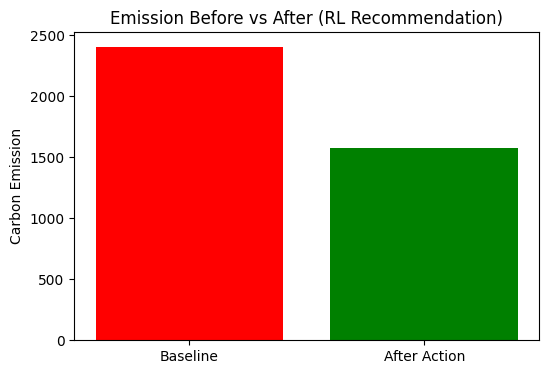

In [21]:
# ============== 9) Sanity Check: Baseline vs RL Action ==============

# Reload saved pipeline
pipe = joblib.load(os.path.join(MODELS_DIR, "carbon_rf_pipeline_final.joblib"))

# Pick a random sample from test set
sample = X_test_raw.sample(1, random_state=7).copy()
feat_sample = build_features(sample)
baseline = float(pipe.predict(feat_sample)[0])

print("Sample lifestyle row (raw):")
display(sample)
print(f"Baseline predicted emission: {baseline:.2f}")

# Check if RL agent exists
agent_path = os.path.join(MODELS_DIR, "dqn_carbon_agent_final.zip")
has_agent = SB3_AVAILABLE and os.path.exists(agent_path)

# Function to apply action rules
def apply_action_for_app(row: dict, action: str):
    r = row.copy()
    if action == "reduce_car_frequency":
        if "Vehicle Monthly Distance Km" in r:
            r["Vehicle Monthly Distance Km"] = max(0, int(r["Vehicle Monthly Distance Km"] * 0.7))
        if str(r.get("Transport","")).lower() == "private":
            r["Transport"] = "public"
    elif action == "switch_to_public_transport":
        r["Transport"] = "public"
    elif action == "reduce_meat_consumption":
        r["Diet"] = "vegetarian"
    elif action == "switch_to_renewable_energy":
        r["Heating Energy Source"] = "renewable"
        r["Energy efficiency"] = "high"
    elif action == "increase_recycling":
        cur = str(r.get("Recycling","") or "")
        parts = set([p for p in cur.split("|") if p])
        parts.update(["paper","plastic"])
        r["Recycling"] = "|".join(sorted(parts))
    return r

recommended_action = None
new_emission = None

if has_agent:
    from stable_baselines3 import DQN
    agent = DQN.load(agent_path)

    obs = pipe.named_steps["preprocessor"].transform(
        build_features(sample)
    ).astype("float32")

    action_idx, _ = agent.predict(obs[0], deterministic=True)
    recommended_action = ACTIONS[int(action_idx)]

    # Apply action to raw row, then rebuild features
    mod = apply_action_for_app(sample.iloc[0].to_dict(), recommended_action)
    feat_mod = build_features(pd.DataFrame([mod]))
    new_emission = float(pipe.predict(feat_mod)[0])

    print("Recommended action:", recommended_action)
    print(f"After-action predicted emission: {new_emission:.2f}")
else:
    print("[INFO] No RL agent found — skipping recommendation simulation.")

# Plot comparison
if new_emission is not None:
    plt.figure(figsize=(6,4))
    plt.bar(["Baseline","After Action"], [baseline, new_emission], color=["red","green"])
    plt.ylabel("Carbon Emission")
    plt.title("Emission Before vs After (RL Recommendation)")
    plt.show()